<a href="https://colab.research.google.com/github/mad0101/BDMH_BCP/blob/main/Sampling-Techniques-Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0.0 Check Available GPU/ CPU

In [1]:
!nvidia-smi

Tue Dec  5 13:25:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 0.1 Install Required Packages

In [2]:
!pip install git+https://github.com/modAL-python/modAL.git skorch

  Cloning https://github.com/modAL-python/modAL.git to /tmp/pip-req-build-vpy_l7u5
  Running command git clone --filter=blob:none --quiet https://github.com/modAL-python/modAL.git /tmp/pip-req-build-vpy_l7u5
  Resolved https://github.com/modAL-python/modAL.git to commit bba6f6fd00dbb862b1e09259b78caf6cffa2e755
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 11.7 MB/s eta 0:00:00
  Created wheel for modAL-python: filename=modAL_python-0.4.2-py3-none-any.whl size=32650 sha256=1384262c83c70c40137e3043d50c5262428304d18841a7a999636c07b94e5edd
  Stored in directory: /tmp/pip-ephem-wheel-cache-jhh91m0n/wheels/d9/fb/59/7deb61b460c1c36394cd093758986ff7d36f71352dcb2e02c5
Successfully built modAL-python


## 1.0 Load Packages

In [3]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import scipy as sp
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from modAL.models import ActiveLearner, BayesianOptimizer
from scipy import stats
from scipy.ndimage.filters import gaussian_filter1d
from scipy.spatial.distance import pdist, squareform
from skorch import NeuralNetClassifier
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split

<ipython-input-3-5d0e6c78b693>:17: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


## 1.1 Load Datasets

In [4]:
def tensor_to_np(tensor_data: torch.Tensor) -> np.ndarray:
    """Since Skorch doesn not support dtype of torch.Tensor, we will modify
    the dtype to numpy.ndarray
    Attribute:
        tensor_data: Data of class type=torch.Tensor
    """
    np_data = tensor_data.detach().numpy()
    return np_data

In [5]:
TRAIN_SIZE = 10000
VAL_SIZE = 300
POOL_SIZE = 60000 - TRAIN_SIZE - VAL_SIZE

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

mnist_train = MNIST(".", train=True, download=True, transform=transform)
mnist_test = MNIST(".", train=False, download=True, transform=transform)


train_set, val_set, pool_set = random_split(
    mnist_train, [TRAIN_SIZE, VAL_SIZE, POOL_SIZE]
)
train_loader = DataLoader(dataset=train_set, batch_size=TRAIN_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=VAL_SIZE, shuffle=True)
pool_loader = DataLoader(dataset=pool_set, batch_size=POOL_SIZE, shuffle=True)
test_loader = DataLoader(dataset=mnist_test, batch_size=10000, shuffle=True)


X_train_All, y_train_All = next(iter(train_loader))
X_val, y_val = next(iter(val_loader))
X_pool, y_pool = next(iter(pool_loader))
X_test, y_test = next(iter(test_loader))

100%|██████████| 9912422/9912422 [00:00<00:00, 27407003.18it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 97219657.96it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25405242.75it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18604032.00it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



To build a binary classification model for MNIST, we will first select the target number. (For instance, digit 9) Next, change the label to True or False, if image==9, return True and vice versa.

In [7]:
y_train_All_9 = y_train_All == 9
y_val_9 = y_val == 9
y_pool_9 = y_pool == 9
y_test_9 = y_test == 9

In [9]:
initial_idx = np.array([], dtype=int)
state = True

for i in range(2):
    idx = np.random.choice(np.where(y_train_All_9 == state)[0], size=10, replace=False)
    initial_idx = np.concatenate((initial_idx, idx))
    state = False


X_init = X_train_All[initial_idx]
y_init_9 = y_train_All_9[initial_idx]


print(f"Initial training data points: {X_init.shape[0]}")
print(f"Data distribution for each class: {np.bincount(y_init_9)}")

Initial training data points: 20
Data distribution for each class: [10 10]


In [10]:
X_init = tensor_to_np(X_init)
y_init = tensor_to_np(y_init_9).astype(int)
X_val = tensor_to_np(X_val)
y_val = tensor_to_np(y_val_9).astype(int)
X_pool = tensor_to_np(X_pool)
y_pool = tensor_to_np(y_pool_9).astype(int)
X_test = tensor_to_np(X_test)
y_test = tensor_to_np(y_test_9).astype(int)


print(f"Data type: {type(X_test)}")

Data type: <class 'numpy.ndarray'>


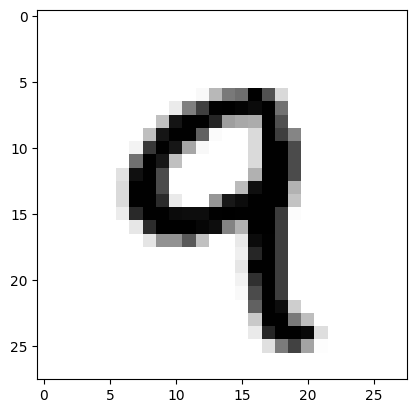

This digit is equal to 9: 1


In [11]:
random_idx = np.random.randint(0, 20)
random_digit = X_init[random_idx]
random_digit_img = random_digit.reshape(28, 28)

plt.imshow(random_digit_img, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("on")
plt.show()

print(f"This digit is equal to 9: {y_init[random_idx]}")  # If True, return 1, else 0

## 2.0 Acquisition Functions
* Random (Uniform): baseline
* Max Entropy
* BALD
* Var Ratios
* Informative Cluster

In [12]:
from sklearn.cluster import MiniBatchKMeans

In [13]:
def predictions_from_pool(
    model, X_pool: np.ndarray, T: int = 100, training: bool = True
):
    """Run random_subset prediction on model and return the output
    Attributes:
        X_pool: Pool set to select uncertainty,
        T: Number of MC dropout iterations aka training iterations,
        training: If False, run test without MC dropout. (default=True)
    """
    random_subset = np.random.choice(range(len(X_pool)), size=500, replace=False)
    with torch.no_grad():
        outputs = np.stack(
            [
                torch.softmax(
                    model.estimator.forward(X_pool[random_subset], training=training),
                    dim=-1,
                )
                .cpu()
                .numpy()
                for _ in range(T)
            ]
        )
    return outputs, random_subset


def uniform(
    model, X_pool: np.ndarray, n_query: int = 10, T: int = 100, training: bool = True
):
    """Baseline acquisition a(x) = unif() with unif() a function
    returning a draw from a uniform distribution over the interval [0,1].
    Using this acquisition function is equivalent to choosing a point
    uniformly at random from the pool.
    Attributes:
        X_pool: Pool set to select uncertainty,
        n_query: Number of points that randomly select from pool set,
        training: If False, run test without MC dropout. (default=True)
    """
    query_idx = np.random.choice(range(len(X_pool)), size=n_query, replace=False)
    return query_idx, X_pool[query_idx]


def shannon_entropy_function(
    model, X_pool: np.ndarray, T: int = 100, E_H: bool = False, training: bool = True
):
    """H[y|x,D_train] := - sum_{c} p(y=c|x,D_train)log p(y=c|x,D_train)
    Attributes:
        model: Model that is ready to measure uncertainty after training,
        X_pool: Pool set to select uncertainty,
        T: Number of MC dropout iterations aka training iterations,
        E_H: If True, compute H and EH for BALD (default: False),
        training: If False, run test without MC dropout. (default=True)
    """
    outputs, random_subset = predictions_from_pool(model, X_pool, T, training=training)
    pc = outputs.mean(axis=0)
    H = (-pc * np.log(pc + 1e-10)).sum(
        axis=-1
    )  # To avoid division with zero, add 1e-10
    if E_H:
        E = -np.mean(np.sum(outputs * np.log(outputs + 1e-10), axis=-1), axis=0)
        return H, E, random_subset
    return H, random_subset


def max_entropy(
    model, X_pool: np.ndarray, n_query: int = 10, T: int = 100, training: bool = True
):
    """Choose pool points that maximise the predictive entropy.
    Using Shannon entropy function.
    Attributes:
        model: Model that is ready to measure uncertainty after training,
        X_pool: Pool set to select uncertainty,
        n_query: Number of points that maximise max_entropy a(x) from pool set,
        T: Number of MC dropout iterations aka training iterations,
        training: If False, run test without MC dropout. (default=True)
    """
    acquisition, random_subset = shannon_entropy_function(
        model, X_pool, T, training=training
    )
    idx = (-acquisition).argsort()[:n_query]
    query_idx = random_subset[idx]
    return query_idx, X_pool[query_idx]


def bald(
    model, X_pool: np.ndarray, n_query: int = 10, T: int = 100, training: bool = True
):
    """Choose pool points that are expected to maximise the information
    gained about the model parameters, i.e. maximise the mutal information
    between predictions and model posterior. Given
    I[y,w|x,D_train] = H[y|x,D_train] - E_{p(w|D_train)}[H[y|x,w]]
    with w the model parameters (H[y|x,w] is the entropy of y given w).
    Points that maximise this acquisition function are points on which the
    model is uncertain on average but there exist model parameters that produce
    disagreeing predictions with high certainty. This is equivalent to points
    with high variance in th einput to the softmax layer
    Attributes:
        model: Model that is ready to measure uncertainty after training,
        X_pool: Pool set to select uncertainty,
        n_query: Number of points that maximise bald a(x) from pool set,
        T: Number of MC dropout iterations aka training iterations,
        training: If False, run test without MC dropout. (default=True)
    """
    H, E_H, random_subset = shannon_entropy_function(
        model, X_pool, T, E_H=True, training=training
    )
    acquisition = H - E_H
    idx = (-acquisition).argsort()[:n_query]
    query_idx = random_subset[idx]
    return query_idx, X_pool[query_idx]


def var_ratios(
    model, X_pool: np.ndarray, n_query: int = 10, T: int = 100, training: bool = True
):
    """Like Max Entropy but Variational Ratios measures lack of confidence.
    Given: variational_ratio[x] := 1 - max_{y} p(y|x,D_{train})
    Attributes:
        model: Model that is ready to measure uncertainty after training,
        X_pool: Pool set to select uncertainty,
        n_query: Number of points that maximise var_ratios a(x) from pool set,
        T: Number of MC dropout iterations aka training iterations,
        training: If False, run test without MC dropout. (default=True)
    """
    outputs, random_subset = predictions_from_pool(model, X_pool, T, training)
    preds = np.argmax(outputs, axis=2)
    _, count = stats.mode(preds, axis=0)
    acquisition = (1 - count / preds.shape[1]).reshape((-1,))
    idx = (-acquisition).argsort()[:n_query]
    query_idx = random_subset[idx]
    return query_idx, X_pool[query_idx]


def informative_cluster_diverse_sampling(model, X_pool, n_query=10, T=100, training=True, n_clusters=10):
    def calculate_min_margin(distances):
        if len(distances.shape) < 2:
            min_margin = np.abs(distances)
        else:
            sort_distances = np.sort(distances, 1)[:, -2:]
            min_margin = sort_distances[:, 1] - sort_distances[:, 0]
        return min_margin

    try:
        distances = model.decision_function(X_pool)
    except:
        distances = model.predict_proba(X_pool)

    min_margin = calculate_min_margin(distances)
    rank_ind = np.argsort(min_margin)

    # Cluster the data
    cluster_model = MiniBatchKMeans(n_clusters=n_clusters, n_init=3)
    cluster_model.fit(X_pool.reshape((X_pool.shape[0], -1)))
    cluster_labels = cluster_model.labels_
    unique, counts = np.unique(cluster_labels, return_counts=True)
    cluster_prob = counts / sum(counts)

    new_batch_cluster_counts = [0] * n_clusters
    query_idx = []

    for i in rank_ind:
        if len(query_idx) == n_query:
            break
        label = cluster_labels[i]
        if new_batch_cluster_counts[label] / n_query < cluster_prob[label]:
            query_idx.append(i)
            new_batch_cluster_counts[label] += 1

    n_slot_remaining = n_query - len(query_idx)
    batch_filler = list(set(rank_ind) - set(query_idx))
    query_idx.extend(batch_filler[:n_slot_remaining])

    return query_idx, X_pool[query_idx]

## 2.1 Define CNN architecture

In [14]:
class ConvNN(nn.Module):
    def __init__(
        self,
        num_filters: int = 32,
        kernel_size: int = 4,
        dense_layer: int = 128,
        img_rows: int = 28,
        img_cols: int = 28,
        maxpool: int = 2,
    ):
        """
        Basic Architecture of CNN
        Attributes:
            num_filters: Number of filters, out channel for 1st and 2nd conv layers,
            kernel_size: Kernel size of convolution,
            dense_layer: Dense layer units,
            img_rows: Height of input image,
            img_cols: Width of input image,
            maxpool: Max pooling size
        """
        super(ConvNN, self).__init__()
        self.conv1 = nn.Conv2d(1, num_filters, kernel_size, 1)
        self.conv2 = nn.Conv2d(num_filters, num_filters, kernel_size, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(
            num_filters
            * ((img_rows - 2 * kernel_size + 2) // 2)
            * ((img_cols - 2 * kernel_size + 2) // 2),
            dense_layer,
        )
        self.fc2 = nn.Linear(dense_layer, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        out = self.fc2(x)
        return out

## 2.2 Define Active Learning Procedure

In [15]:
def active_learning_procedure(
    query_strategy,
    X_val: np.ndarray,
    y_val: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    X_pool: np.ndarray,
    y_pool: np.ndarray,
    X_init: np.ndarray,
    y_init: np.ndarray,
    estimator,
    T: int = 100,
    n_query: int = 10,
    training: bool = True,
):
    """Active Learning Procedure
    Attributes:
        query_strategy: Choose between Uniform(baseline), max_entropy, bald,
        X_val, y_val: Validation dataset,
        X_test, y_test: Test dataset,
        X_pool, y_pool: Query pool set,
        X_init, y_init: Initial training set data points,
        estimator: Neural Network architecture, e.g. CNN,
        T: Number of MC dropout iterations (repeat acqusition process T times),
        n_query: Number of points to query from X_pool,
        training: If False, run test without MC Dropout (default: True)
    """
    learner = ActiveLearner(
        estimator=estimator,
        X_training=X_init,
        y_training=y_init,
        query_strategy=query_strategy,
    )
    perf_hist = [learner.score(X_test, y_test)]
    for index in range(T):
        query_idx, query_instance = learner.query(
            X_pool, n_query=n_query, T=T, training=training
        )
        learner.teach(X_pool[query_idx], y_pool[query_idx])
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)
        model_accuracy_val = learner.score(X_val, y_val)
        if (index + 1) % 5 == 0:
            print(f"Val Accuracy after query {index+1}: {model_accuracy_val:0.4f}")
        perf_hist.append(model_accuracy_val)
    model_accuracy_test = learner.score(X_test, y_test)
    print(f"********** Test Accuracy per experiment: {model_accuracy_test} **********")
    return perf_hist, model_accuracy_test

## 3.0 Define Hyperparameters

In [20]:
ACQ_FUNCS = [informative_cluster_diverse_sampling,uniform, max_entropy, bald, var_ratios]
BATCH_SIZE = 128
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DROPOUT_ITER = 100
EPOCHS = 50
EXPERIMENTS = 1
N_QUERY = 10
LR = 1e-3
RESULT_DIR = "result_npy"
SEED = 369


if not os.path.exists(RESULT_DIR):
    os.mkdir(RESULT_DIR)


print(f"Using device: {DEVICE}")

Using device: cuda:0


## 3.1 Functions

In [21]:
def load_CNN_model():
    """Load new model each time for different acqusition function
    each experiments"""
    model = ConvNN().to(DEVICE)
    cnn_classifier = NeuralNetClassifier(
        module=model,
        lr=LR,
        batch_size=BATCH_SIZE,
        max_epochs=EPOCHS,
        criterion=nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        train_split=None,
        verbose=0,
        device=DEVICE,
    )
    return cnn_classifier


def save_as_npy(data: np.ndarray, name: str):
    """Save result as npy file

    Attributes:
        data: np array to be saved as npy file,
        folder: result folder name,
        name: npy filename
    """
    file_name = os.path.join(RESULT_DIR, name + ".npy")
    np.save(file_name, data)
    print(f"Saved: {file_name}")


def plot_results(data: dict):
    """Plot results histogram using matplotlib"""
    sns.set()
    plt.figure(figsize=(7, 5))
    for key in data.keys():
        data[key] = gaussian_filter1d(data[key], sigma=0.9)  # for smoother graph
        plt.plot(data[key], label=key)
    plt.ylim([0.94, 1.00])
    plt.legend()
    plt.show()


def print_elapsed_time(start_time: float, exp: int, acq_func: str):
    """Print elapsed time for each experiment of acquiring
    Attributes:
        start_time: Starting time (in time.time()),
        exp: Experiment iteration
        acq_func: Name of acquisition function
    """
    elp = time.time() - start_time
    print(
        f"********** Experiment {exp} ({acq_func}): {int(elp//3600)}:\
        {int(elp%3600//60)}:{int(elp%60)} **********"
    )

## 4.0 Start Active Learning with Acquisition Functions
- random
- max_entropy
- bald
- var ratios

In [22]:
results = dict()


for i, acq_func in enumerate(ACQ_FUNCS):
    avg_hist = []
    test_scores = []
    acq_func_name = str(acq_func).split(" ")[1]
    print(f"\n---------- Start {acq_func_name} training! ----------")
    for e in range(EXPERIMENTS):
        start_time = time.time()
        estimator = load_CNN_model()
        print(f"********** Experiment Iterations: {e+1}/{EXPERIMENTS} **********")
        training_hist, test_score = active_learning_procedure(
            query_strategy=acq_func,
            X_val=X_val,
            y_val=y_val,
            X_test=X_test,
            y_test=y_test,
            X_pool=X_pool,
            y_pool=y_pool,
            X_init=X_init,
            y_init=y_init,
            estimator=estimator,
            T=DROPOUT_ITER,
            n_query=N_QUERY,
        )
        avg_hist.append(training_hist)
        test_scores.append(test_score)
        print_elapsed_time(start_time, e + 1, acq_func_name)
    avg_hist = np.average(np.array(avg_hist), axis=0)
    avg_test = sum(test_scores) / len(test_scores)
    print(f"Average Test score for {acq_func_name}: {avg_test}")
    results[acq_func_name] = avg_hist
    save_as_npy(data=avg_hist, name=acq_func_name)


print("--------------- Done Training! ---------------")


---------- Start informative_cluster_diverse_sampling training! ----------
********** Experiment Iterations: 1/1 **********
Val Accuracy after query 5: 0.9633
Val Accuracy after query 10: 0.9867
Val Accuracy after query 15: 0.9900
Val Accuracy after query 20: 0.9933
Val Accuracy after query 25: 0.9967
Val Accuracy after query 30: 0.9900
Val Accuracy after query 35: 0.9867
Val Accuracy after query 40: 0.9967
Val Accuracy after query 45: 0.9967
Val Accuracy after query 50: 0.9933
Val Accuracy after query 55: 0.9967
Val Accuracy after query 60: 1.0000
Val Accuracy after query 65: 1.0000
Val Accuracy after query 70: 1.0000
Val Accuracy after query 75: 1.0000
Val Accuracy after query 80: 0.9967
Val Accuracy after query 85: 1.0000
Val Accuracy after query 90: 1.0000
Val Accuracy after query 95: 1.0000
Val Accuracy after query 100: 1.0000
********** Test Accuracy per experiment: 0.996 **********
********** Experiment 1 (informative_cluster_diverse_sampling): 0:        5:43 **********
Average

## 4.1 Plot Deep Bayesian Active Learning Results

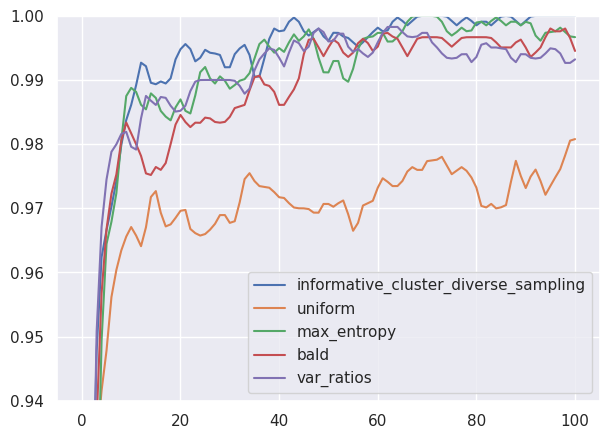

In [23]:
plot_results(data=results)

## 5.0 MBR - Kernel Matrix (W)
Use 20 initial datapoints.

In [24]:
from sklearn.metrics.pairwise import rbf_kernel


def kernel_matrix(X_datapoints):
    X_datapoints = X_datapoints.reshape(X_datapoints.shape[0], -1)
    W = rbf_kernel(X_datapoints, X_datapoints)
    return W

## 5.1 MBR - Combinatorial Laplacian (Delta)

In [25]:
def combinatorial_laplacian(W):
    """Compute the combinatorial laplacian given edge weight matrix W"""
    # the degree matrix -- sum up edge weights for each node
    D = np.diag(np.sum(W, axis=1))

    # the combinatorial laplacian
    Delta = D - W
    return Delta


def to_categorical(y, num_classes=2):
    """1-hot encodes a tensor"""
    return np.eye(num_classes, dtype="uint8")[y]

## 5.2 MBR - Harmonic Function

In [26]:
def harmonic_function(X_train, y_train, Delta):
    Delta_ll = Delta[0 : X_train.shape[0], 0 : X_train.shape[0]]
    Delta_ul = Delta[X_train.shape[0] :, 0 : X_train.shape[0]]
    Delta_lu = Delta[0 : X_train.shape[0], X_train.shape[0] :]
    Delta_uu = Delta[X_train.shape[0] :, X_train.shape[0] :]

    inv_Delta_uu = np.linalg.pinv(Delta_uu)
    Original_f_L = y_train
    Delta_mult = np.dot(inv_Delta_uu, Delta_ul)
    Original_f_U = -np.dot(Delta_mult, Original_f_L)

    # f_I is the entire harmonic function over all the data points (U + L)
    Original_f_I = np.concatenate((Original_f_L, Original_f_U), axis=0)
    return Original_f_I, Original_f_L

## 5.3 Compute Bayes Risk

In [27]:
def minimum_bayes_risk(
    model, X_pool, y_pool, X_train, y_train, Delta, n_query, Original_f_I, Original_f_L
):
    """Compute Bayes Risk for all pool points in acquisition iteration"""
    pool_subset_idx = np.random.choice(range(len(X_pool)), size=1000, replace=False)
    X_pool_points = X_pool[pool_subset_idx]
    y_pool_points = y_pool[pool_subset_idx]
    X_train_temp = np.concatenate((X_train, X_pool_points), axis=0)
    y_train_temp = np.concatenate((y_train, y_pool_points), axis=0)
    X_pool_temp = np.delete(X_pool, pool_subset_idx, axis=0)

    f_I, f_l = harmonic_function(X_train_temp, y_train_temp, Delta)

    # Compute new estimate Bayes Risk
    R = np.array([0])
    for m in range(f_I.shape[0]):
        val_f_I = f_I[m]
        other_val_f_I = 1 - val_f_I
        min_val = np.amin(np.array([val_f_I, other_val_f_I]))
        R = R + min_val
    Estimated_Risk = R

    # we need f_k values for each pool point in consideration
    f_All_Pool = Original_f_I[Original_f_L.shape[0] :]
    f_k = f_All_Pool[500]
    Bayes_Risk = (1 - f_k) * Estimated_Risk + (f_k) * Estimated_Risk

    query_idx = np.argsort(Bayes_Risk.flatten())[-n_query:]
    return query_idx, X_pool[query_idx]

## 6.0 Define MBR Procedure

In [28]:
def MBR_procedure(
    X_val: np.ndarray,
    y_val: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    X_pool: np.ndarray,
    y_pool: np.ndarray,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_init: np.ndarray,
    y_init: np.ndarray,
    estimator,
    T: int = 100,
    n_query: int = 10,
    query_strategy=minimum_bayes_risk,
):
    """MBR Procedure
    Attributes:
        X_val, y_val: Validation dataset,
        X_test, y_test: Test dataset,
        X_pool, y_pool: Query pool set,
        X_train, y_train: Training set,
        X_init, y_init: Initial training set,
        estimator: Neural Network architecture, e.g. CNN,
        T: Number of iterations (repeat acqusition process T times),
        n_query: Number of points to query from X_pool,
        query_strategy: MBR to query points from pool
    """
    learner = ActiveLearner(
        estimator=estimator,
        X_training=X_init,
        y_training=y_init,
        query_strategy=query_strategy,
    )
    perf_hist = [learner.score(X_test, y_test)]

    X_train_pool = np.concatenate((X_train, X_pool), axis=0)
    W = kernel_matrix(X_train_pool)
    delta = combinatorial_laplacian(W)
    print(f"Delta shape: {delta.shape} (n*n)")

    original_f_I, original_f_L = harmonic_function(X_train, y_train, delta)

    for index in range(T):
        query_idx, query_instance = learner.query(
            X_pool=X_pool,
            y_pool=y_pool,
            X_train=X_train,
            y_train=y_train,
            Delta=delta,
            Original_f_I=original_f_I,
            Original_f_L=original_f_L,
            n_query=10,
        )
        learner.teach(X_pool[query_idx], y_pool[query_idx])
        X_train = np.concatenate((X_train, X_pool[query_idx]), axis=0)
        y_train = np.concatenate((y_train, y_pool[query_idx]), axis=0)
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)

        model_accuracy_val = learner.score(X_val, y_val)
        if (index + 1) % 5 == 0:
            print(f"Val Accuracy after iteration {index+1}: {model_accuracy_val:0.4f}")
        perf_hist.append(model_accuracy_val)
    model_accuracy_test = learner.score(X_test, y_test)
    print(f"********** Test Accuracy per experiment: {model_accuracy_test} **********")
    return perf_hist, model_accuracy_test

## 6.1 Choose 3 different pool dataset

In [29]:
X_pool_1 = X_pool[:2000]
y_pool_1 = y_pool[:2000]
X_pool_2 = X_pool[6000:8000]
y_pool_2 = y_pool[6000:8000]
X_pool_3 = X_pool[10000:12000]
y_pool_3 = y_pool[10000:12000]


X_pool_list = [X_pool_1, X_pool_2, X_pool_3]
y_pool_list = [y_pool_1, y_pool_2, y_pool_3]
print(len(X_pool_list))
print(X_pool_list[2].shape)

3
(2000, 1, 28, 28)


## 7.0 Start MBR Training

In [30]:
print(f"Using X_pool size of: {X_pool_1.shape}, {len(X_pool_list)} sets.")
avg_hist = []

for e in range(3):
    estimator = load_CNN_model()
    print(f"Done load model!")
    X_pool = X_pool_list[e]
    y_pool = y_pool_list[e]
    start_time = time.time()
    hist, acc = MBR_procedure(
        X_val=X_val,
        y_val=y_val,
        X_test=X_test,
        y_test=y_test,
        X_pool=X_pool,
        y_pool=y_pool,
        X_train=X_init,
        y_train=y_init,
        X_init=X_init,
        y_init=y_init,
        estimator=estimator,
    )
    print_elapsed_time(start_time=start_time, exp=e + 1, acq_func="MBR")
    avg_hist.append(hist)

result = np.mean(np.array(avg_hist), axis=0)

Using X_pool size of: (2000, 1, 28, 28), 3 sets.
Done load model!
Delta shape: (2020, 2020) (n*n)
Val Accuracy after iteration 5: 0.6533
Val Accuracy after iteration 10: 0.8600
Val Accuracy after iteration 15: 0.9200
Val Accuracy after iteration 20: 0.9033
Val Accuracy after iteration 25: 0.9133
Val Accuracy after iteration 30: 0.9033
Val Accuracy after iteration 35: 0.9200
Val Accuracy after iteration 40: 0.9067
Val Accuracy after iteration 45: 0.9033
Val Accuracy after iteration 50: 0.9033
Val Accuracy after iteration 55: 0.9033
Val Accuracy after iteration 60: 0.9433
Val Accuracy after iteration 65: 0.9267
Val Accuracy after iteration 70: 0.9200
Val Accuracy after iteration 75: 0.9000
Val Accuracy after iteration 80: 0.8933
Val Accuracy after iteration 85: 0.9400
Val Accuracy after iteration 90: 0.9367
Val Accuracy after iteration 95: 0.9467
Val Accuracy after iteration 100: 0.9533
********** Test Accuracy per experiment: 0.9514 **********
********** Experiment 1 (MBR): 0:        2:

In [31]:
uniform = np.load("result_npy/uniform.npy")
bald = np.load("result_npy/bald.npy")
max_entropy = np.load("result_npy/max_entropy.npy")
var_ratios = np.load("result_npy/var_ratios.npy")
informative_cluster_diverse_sampling = np.load("result_npy/informative_cluster_diverse_sampling.npy")

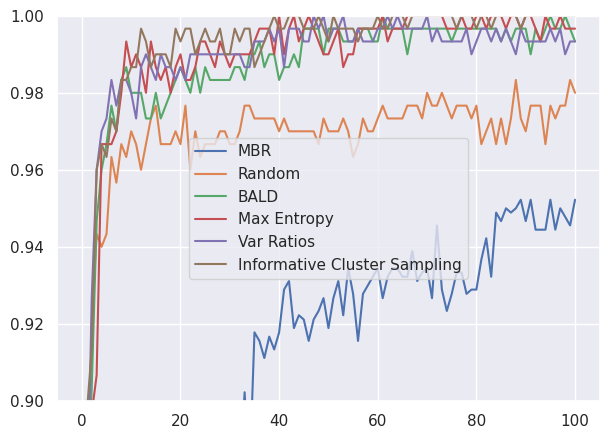

In [33]:
sns.set()
plt.figure(figsize=(7, 5))

result = gaussian_filter1d(result, sigma=0.2)  # for smoother graph
uniform = gaussian_filter1d(uniform, sigma=0.2)
bald = gaussian_filter1d(bald, sigma=0.2)
max_entropy = gaussian_filter1d(max_entropy, sigma=0.2)
var_ratios = gaussian_filter1d(var_ratios, sigma=0.2)

plt.plot(result, label="MBR")
plt.plot(uniform, label="Random")
plt.plot(bald, label="BALD")
plt.plot(max_entropy, label="Max Entropy")
plt.plot(var_ratios, label="Var Ratios")
plt.plot(informative_cluster_diverse_sampling, label="Informative Cluster Sampling")

plt.ylim([0.90, 1])
plt.legend()
plt.show()